In [ ]:
install.packages("caret")
library(caret)
library(tidyverse)
library(data.table)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to beco

In [ ]:
#https://drive.google.com/file/d/1DFgivEc51cpPiTrFGW1XxEoBWEEo-cWX/view?usp=drive_link
system("gdown --id 1DFgivEc51cpPiTrFGW1XxEoBWEEo-cWX")
system("ls", TRUE)

[1] "games_may2024_cleaned.csv" "sample_data"

In [ ]:
data <- fread("/content/games_may2024_cleaned.csv") %>% as_tibble()
data %>% str()

tibble [83,646 × 46] (S3: tbl_df/tbl/data.frame)
 $ AppID                   : int [1:83646] 730 578080 570 271590 359550 440 105600 4000 252490 1172470 ...
 $ name                    : chr [1:83646] "Counter-Strike 2" "PUBG: BATTLEGROUNDS" "Dota 2" "Grand Theft Auto V" ...
 $ release_date            : IDate[1:83646], format: "2012-08-21" "2017-12-21" ...
 $ required_age            : int [1:83646] 0 0 0 17 17 0 0 0 17 0 ...
 $ price                   : num [1:83646] 0 0 0 0 20 ...
 $ dlc_count               : int [1:83646] 1 0 2 1 9 1 2 0 4 0 ...
 $ detailed_description    : chr [1:83646] "For over two decades, Counter-Strike has offered an elite competitive experience, one shaped by millions of pla"| __truncated__ "LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS for free. Land on strategic locations, loot weapons and supplies,"| __truncated__ "The most-played game on Steam. Every day, millions of players worldwide enter battle as one of over a hundred D"| __truncated__ "When a young stre

In [ ]:
nrow(data)

[1] 83646

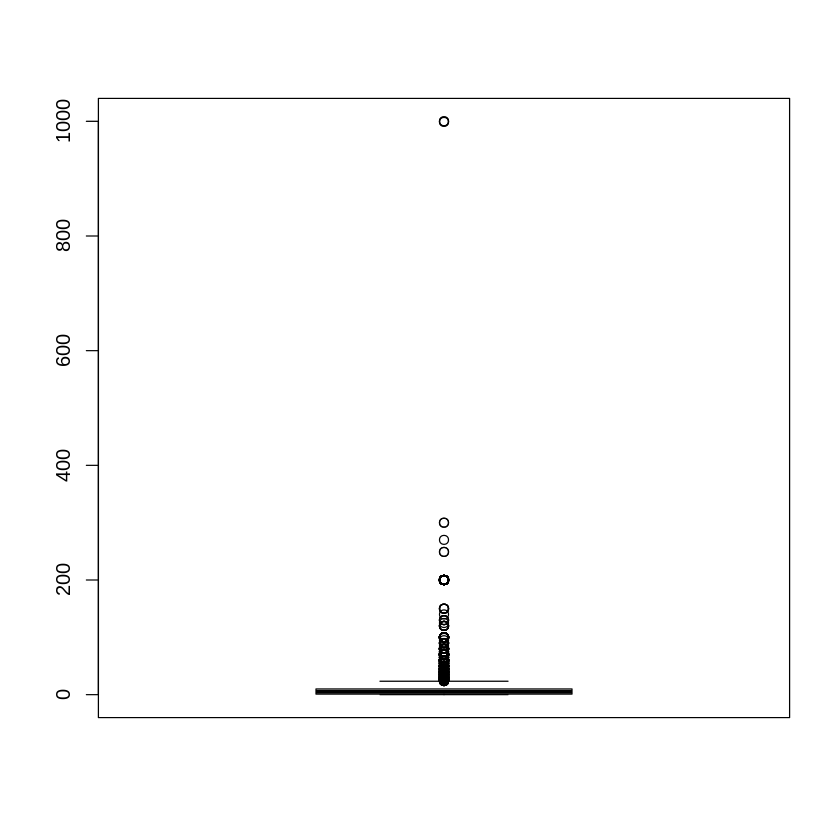

In [ ]:
boxplot(data$price)

**띄어쓰기를 _로 대체**

In [ ]:
colnames(data) <- gsub(" ", "_", colnames(data))

colnames(data)

[1] "AppID"                    "name"                    
 [3] "release_date"             "required_age"            
 [5] "price"                    "dlc_count"               
 [7] "detailed_description"     "about_the_game"          
 [9] "short_description"        "reviews"                 
[11] "header_image"             "website"                 
[13] "support_url"              "support_email"           
[15] "windows"                  "mac"                     
[17] "linux"                    "metacritic_score"        
[19] "metacritic_url"           "achievements"            
[21] "recommendations"          "notes"                   
[23] "supported_languages"      "full_audio_languages"    
[25] "packages"                 "developers"              
[27] "publishers"               "categories"              
[29] "genres"                   "screenshots"             
[31] "movies"                   "user_score"              
[33] "score_rank"               "positive"                
[35] "negative"                 "estimated_owners"        
[37] "average_playtime_forever" "average_playtime_2weeks" 
[39] "median_playtime_forever"  "median_playtime_2weeks"  
[41] "peak_ccu"                 "tags"                    
[43] "pct_pos_total"            "num_reviews_total"       
[45] "pct_pos_recent"           "num_reviews_recent"

**row수가 8만개 이상이므로 줄이기 위해 + 오래된 데이터들은 제외하기 위해 2323~2024로 연도 축소**

In [ ]:
data$release_date <- as.Date(data$release_date, format = "%Y-%m-%d")

filtered_data <- subset(data, release_date >= as.Date("2023-01-01") & release_date <= as.Date("2024-12-31"))


In [ ]:
nrow(filtered_data)

[1] 21136

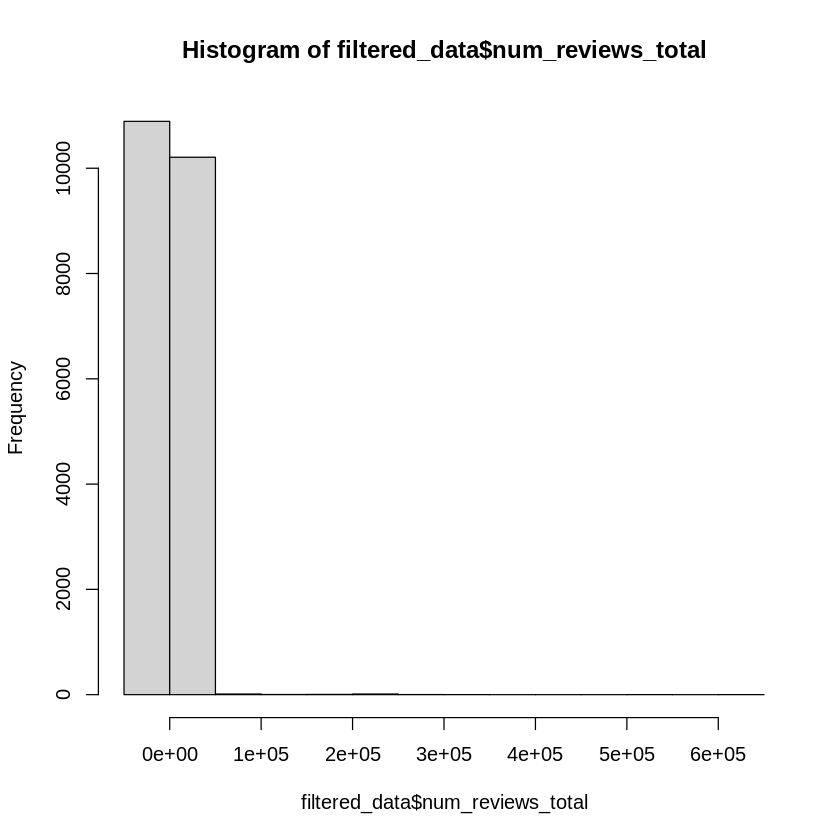

In [ ]:
hist(filtered_data$num_reviews_total)

In [ ]:
summary(filtered_data$num_reviews_total)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     10      18      40    1276     155  641080 

In [ ]:
summary(filtered_data$pct_pos_total)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   73.00   86.00   81.69   94.00  100.00 

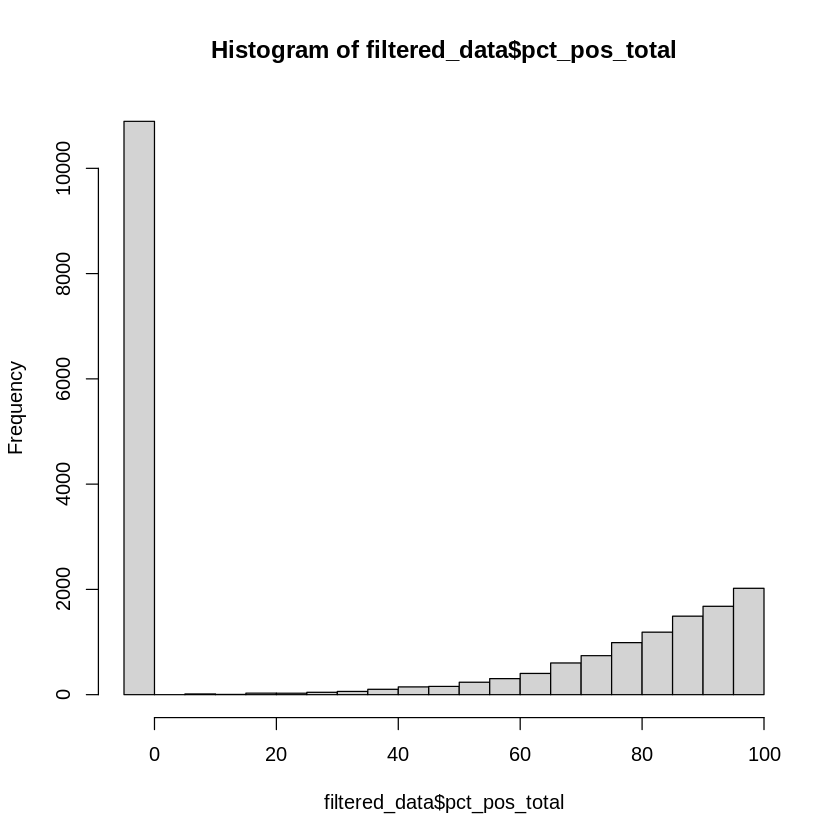

In [ ]:
hist(filtered_data$pct_pos_total)

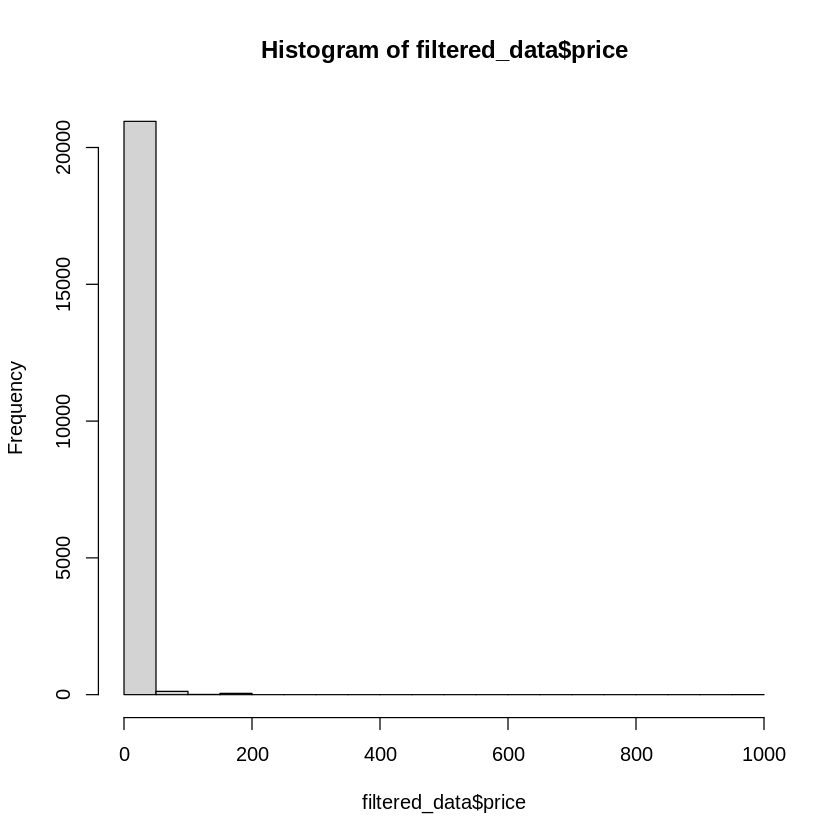

In [ ]:
hist(filtered_data$price)

In [ ]:
filtered_data <- filtered_data %>%
  filter(num_reviews_total >= 0)

In [ ]:
filtered_data <- filtered_data %>%
  filter(pct_pos_total >= 0)

**로그변환 후 히스토그램 재확인**

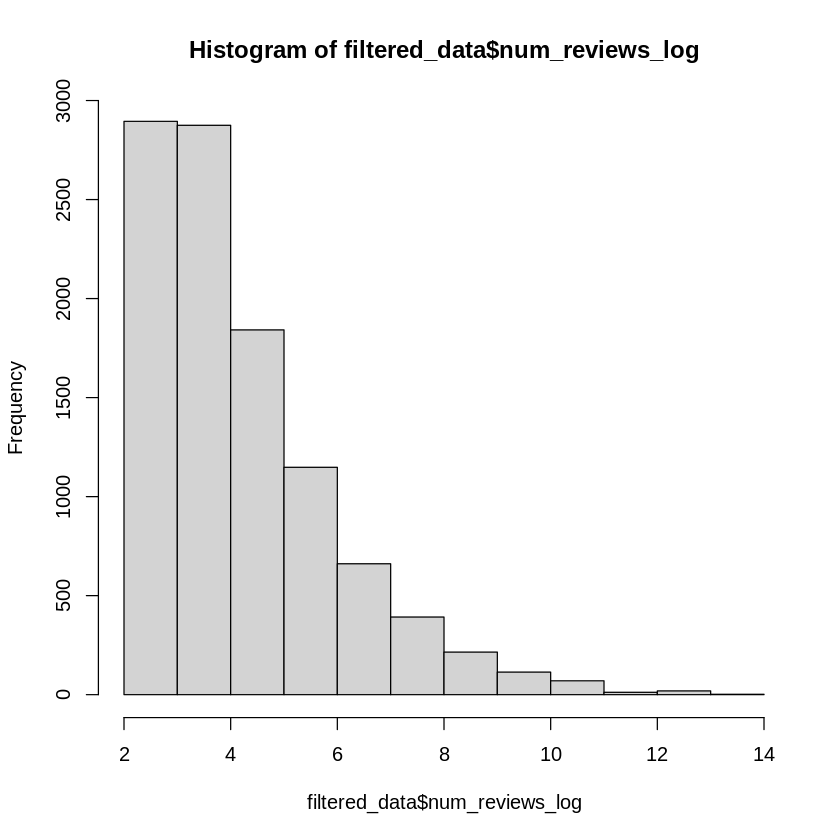

In [ ]:
filtered_data <- filtered_data %>%
  mutate(num_reviews_log = log1p(num_reviews_total))

hist(filtered_data$num_reviews_log)

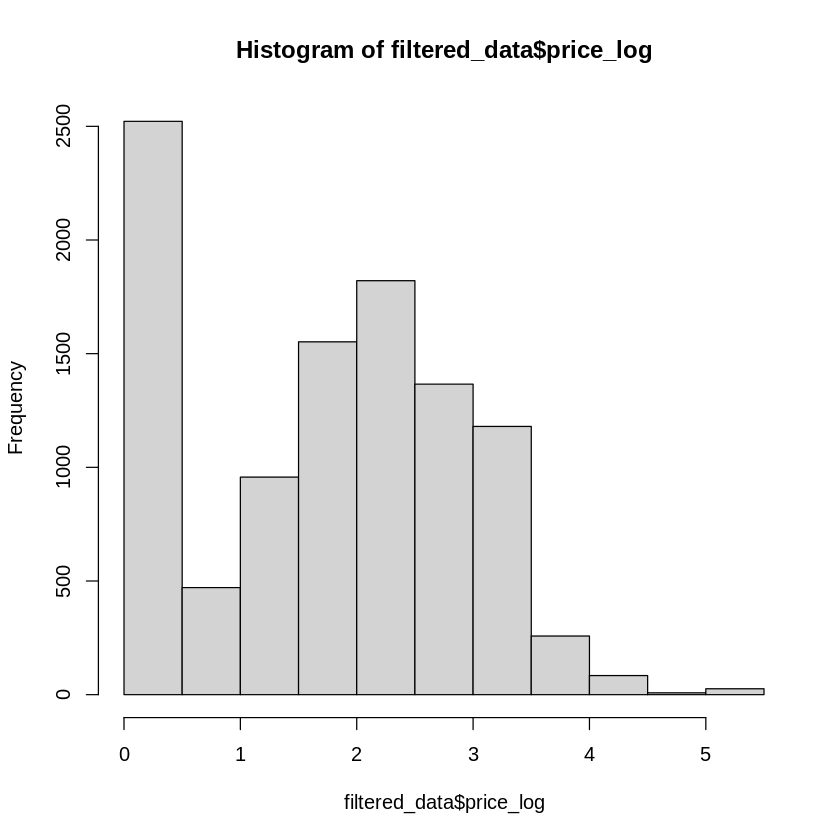

In [ ]:
filtered_data <- filtered_data %>%
  mutate(price_log = log1p(price))

hist(filtered_data$price_log)

**Success 새 반응변수 정의**

In [ ]:
filtered_data <- filtered_data %>%
  mutate(
    num_reviews_log_scaled = (num_reviews_log - min(num_reviews_log)) / (max(num_reviews_log) - min(num_reviews_log)),
    pct_pos_scaled = pct_pos_total / 100
  )

filtered_data <- filtered_data %>%
  mutate(
    success_score = 0.5 * num_reviews_log_scaled + 0.5 * pct_pos_scaled  # 정규화된 값을 사용
  )

# 상위 20% 기준
threshold_score <- quantile(filtered_data$success_score, 0.8, na.rm = TRUE)

# 성공 여부 정의
filtered_data <- filtered_data %>%
  mutate(Success = ifelse(success_score >= threshold_score, 1, 0))


In [ ]:
summary(filtered_data$num_reviews_log)
summary(filtered_data$pct_pos_scaled)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.398   2.944   3.714   4.237   5.050  13.371 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.7300  0.8600  0.8169  0.9400  1.0000 

In [ ]:
table(filtered_data$Success)


   0    1 
8194 2051 

In [ ]:
filtered_data <- filtered_data %>%
  mutate(Success = as.factor(ifelse(success_score >= threshold_score, 1, 0)))


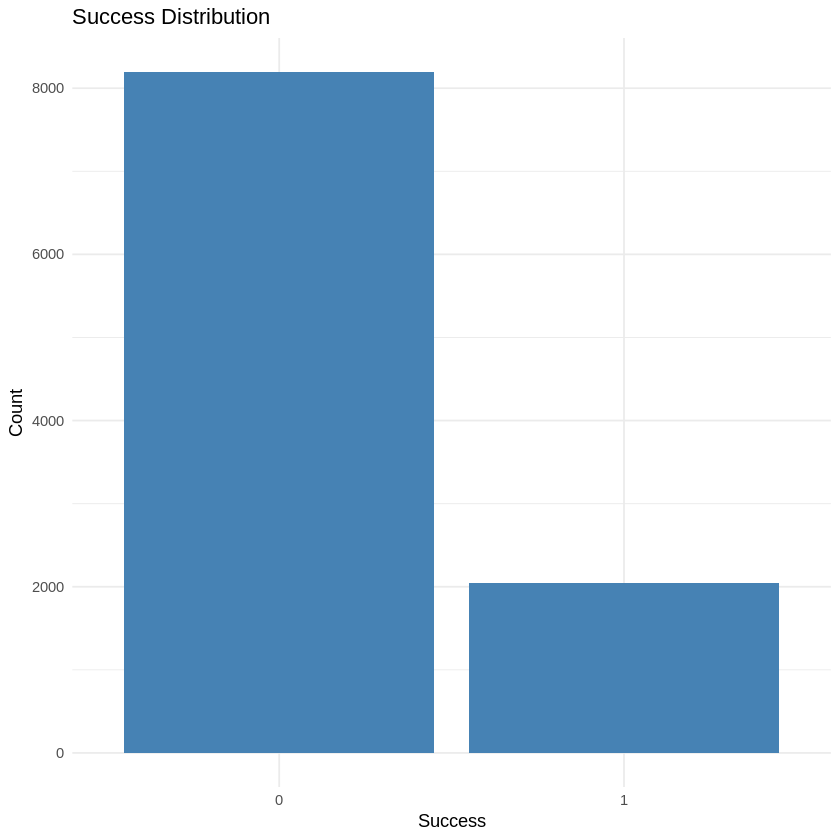

In [ ]:
library(ggplot2)

# success 값의 빈도수 시각화
ggplot(filtered_data, aes(x = Success)) +
  geom_bar(fill = "steelblue") +
  labs(title = "Success Distribution",
       x = "Success",
       y = "Count") +
  theme_minimal()

**결측값 확인 -> 결측값 없으므로 결측값 처리 방법 X**

In [ ]:
na_summary <- colSums(is.na(filtered_data[, c("price", "categories",
                                              "num_reviews_total", "pct_pos_total", "Success",
                                              "genres", "mac", "linux", "windows")]))

print(na_summary)

            price        categories num_reviews_total     pct_pos_total 
                0                 0                 0                 0 
          Success            genres               mac             linux 
                0                 0                 0                 0 
          windows 
                0 


**이상값 확인 -> 총 리뷰 수에 이상값이 나타난 걸로 보이지만, 이 변수는 Success라는 새 반응변수를 만든는데 쓰이므로 유지**

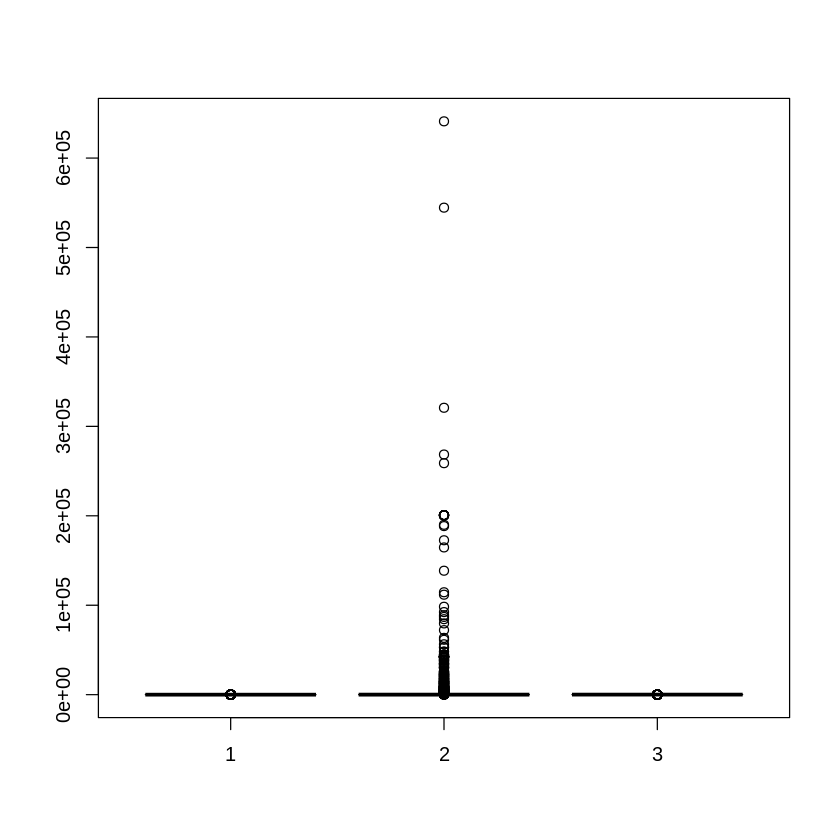

In [ ]:
boxplot(filtered_data$price, filtered_data$num_reviews_total, filtered_data$pct_pos_total)